## Count Surfers in the Water
### Description
This project is to count how many surfers in the water
So you know the surfer traffic in the water.

A typical good sample image as follows: (You can see 3 people are in the water)

In humen brain, it is very easy to count them. Unfortunately, computers need special instructions to do this task

<img src="./Images/SampleImages_001.png" width="600" align="left" />



### Goal
My goal is to let the software automatically count how many people are in the water given series of images (video), this project is to count how many surfers are in the water

### File Structure

./Images - includes all the images

./Videos - includes all the videos

### Various conditions

Wish there are only good days for beach day. But, unfortunately there are many different weather/environment conditions we need to take care!

Condition | Image
------------ | -------------
Fog |	<img src="./Images/Conditions_Fog.png" width="500" align="left" />
Birds |	<img src="./Images/Conditions_Birds.png" width="500" align="left" />
Dark |	<img src="./Images/Conditions_Dark.png" width="500" align="left" />
Poor Image |	<img src="./Images/Conditions_PoorImageQuality.png" width="500" align="left" />



### Possible approaches
- Start from an image
- Set ROI
- Apply color filter to see which one will help?
- Apply Gaussian filter to reduce image noise
- May need different methods for different conditions
- Reduce features (image size)
- Masking the objects

In [115]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

Below block is just to see how each color filter works
Hopefully something can help be identify the surfers

Crop the area so we can separate wave area, we will set region of interest (ROI) later: 
vertices is [350:650,300:1700] [y1:y2, x1:x2]

Total Image size will be 1400 x 300


In [2]:
#bot_left, top_left, top_right, bot_right
vertice = [(300,650),(300,350),(1700,350),(1700,650)]

In [3]:
img = cv2.imread('./Images/SampleImages_001.png')

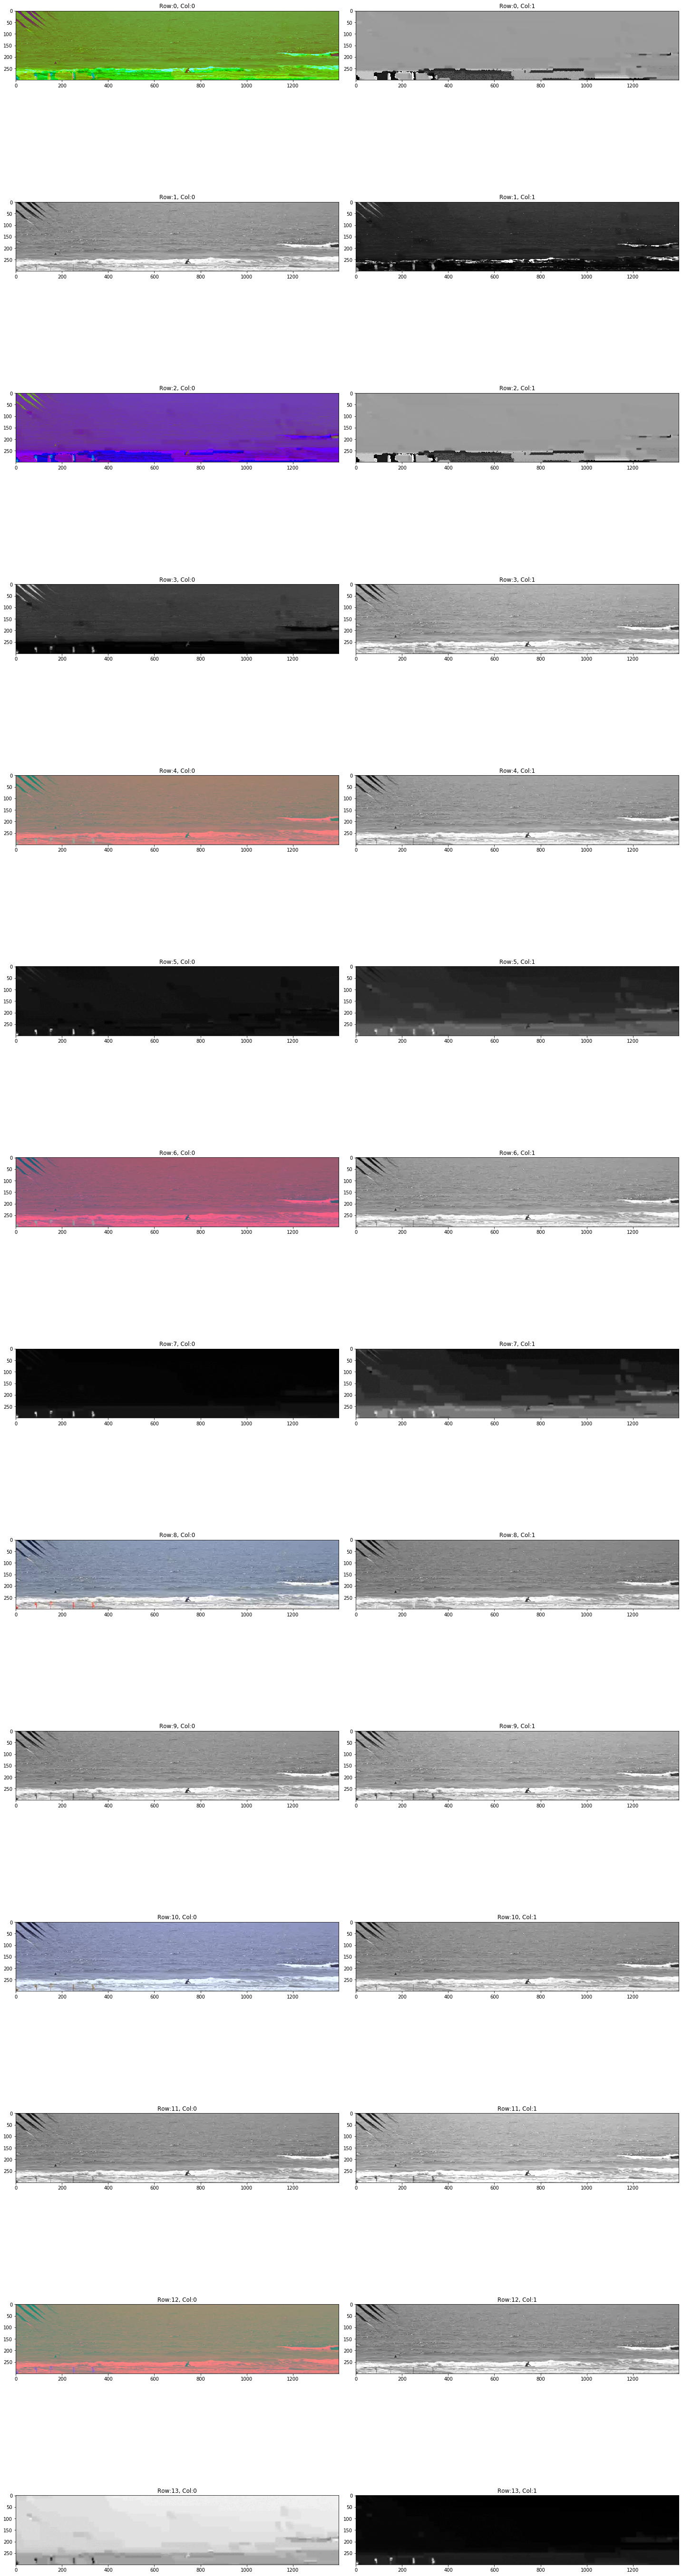

In [4]:
cropped_img = img[350:650,300:1700]
res =[]
def checkColorVariance(img,res,color_code = cv2.COLOR_BGR2HLS):
    temp = []
    temp.append(cv2.cvtColor(img,color_code))
    for i in range(3):
        temp.append(temp[0][:,:,i])
    res += temp
        
checkColorVariance(cropped_img,res,cv2.COLOR_BGR2HLS)
checkColorVariance(cropped_img,res,cv2.COLOR_BGR2HSV)
checkColorVariance(cropped_img,res,cv2.COLOR_BGR2LAB)
checkColorVariance(cropped_img,res,cv2.COLOR_BGR2LUV)
checkColorVariance(cropped_img,res,cv2.COLOR_BGR2RGB)
checkColorVariance(cropped_img,res,cv2.COLOR_BGR2XYZ)
checkColorVariance(cropped_img,res,cv2.COLOR_BGR2YUV)

# Display image function captured from below link    
# https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645

# settings
nrows, ncols = len(res)//2, 2  # array of sub-plots
figsize = [20, 80]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

# plot simple raster image on each sub-plot
for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    img = res[i]
    axi.imshow(img,cmap='gray')

    # get indices of row/column
    rowid = i // ncols
    colid = i % ncols
    # write row/col indices as axes' title for identification
    axi.set_title("Row:"+str(rowid)+", Col:"+str(colid))

plt.tight_layout(True)
plt.show()

Seems like HLS Color filter may help?
Let's see

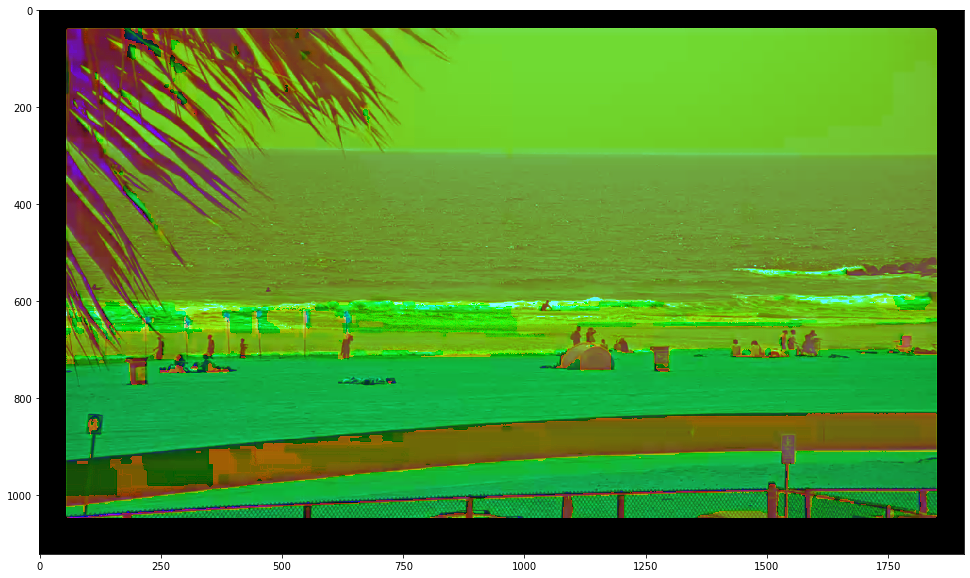

In [5]:
img = cv2.imread('./Images/SampleImages_001.png')
#img_cropped = img[350:650,300:1700]
img_HLS = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)

plt.figure(figsize = (20,10))
plt.imshow(img_HLS, cmap='gray')

It seems like the surfer has obvious distinction.

Now, I will try to apply Gaussian blur to see how it looks like

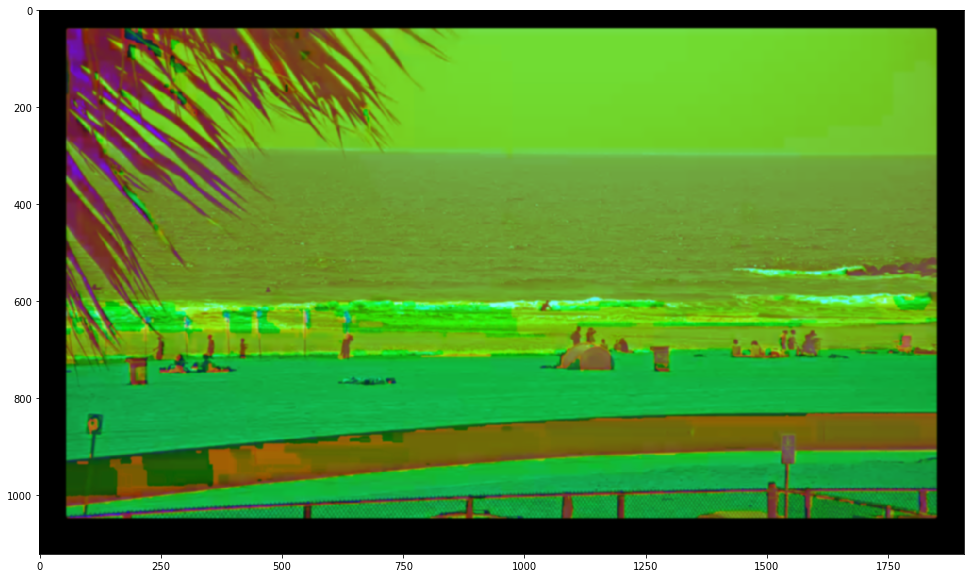

In [6]:
img_gaussian = cv2.GaussianBlur(img_HLS,(9,9),0)
plt.figure(figsize = (20,10))
plt.imshow(img_gaussian, cmap='gray')

The Gaussian Blur blurs the waves, it reduces noise caused by waves

Masking after apply Gaussian:

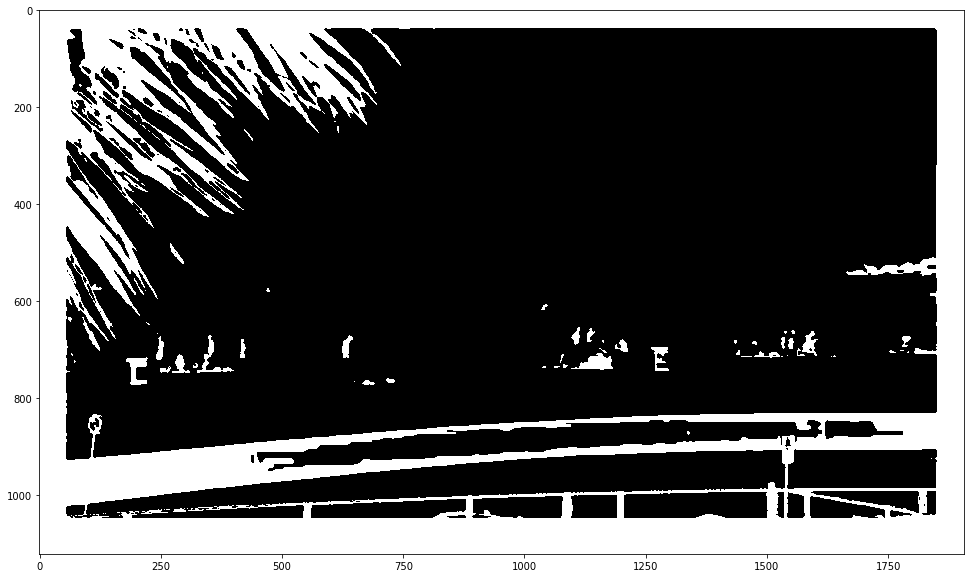

In [7]:
def color_mask(img, low,high):
    return cv2.inRange(img,low,high)
low = np.array([ 0, 0,  0])
high = np.array([255, 100,100])
img_masked = color_mask(img_gaussian,low,high)
plt.figure(figsize = (20,10))
plt.imshow(img_masked, cmap='gray')


Below image is to do the comparison before/after Gaussian. Noise in the image reduced after I apply Gaussian Blur

<img src="./Images/BeforeGaussian.png" align="left" />

Now I need to find ROI vertices. I will hardcode coordinates for now. 

I also want to draw line to visualize which portion of the image I am working on.

https://github.com/peps0791/Udacity-SDCNDP-Lane-Finding/blob/master/Lane-Finding-Project.ipynb


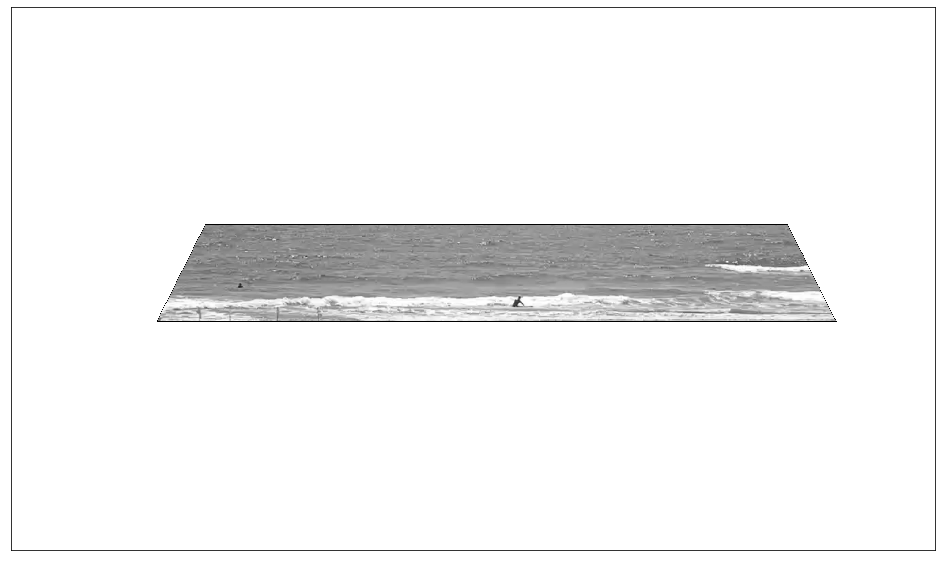

In [53]:

def region_of_interest(img):
    vertices = np.int32([[300,650],[400,450],[1600,450],[1700,650]])
    
    img = cv2.polylines(img, np.int32([vertices]), True,(0,0,0),0)
    mask = np.zeros_like(img)
    
    cv2.fillPoly(mask, np.int32([vertices]), 255)
    
    inverted_mask = cv2.bitwise_not(mask)
    
    masked_image = cv2.bitwise_or(img, inverted_mask)

    return masked_image
    
img = cv2.imread('./Images/SampleImages_001.png')  
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
vertices = region_of_interest_vertices(img)
masked_image = region_of_interest(img)


plt.figure(figsize = (20,10))
fig = plt.imshow(masked_image, cmap='gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)


Now I need to know what are the coordinates for surfers

now we need to draw a box around the white objects we seperated. Let's not worry about the tree
and rock on the right. I will draw region of interest later :)

In [10]:
def draw_box():
    pass

I will define helper functions below

In [ ]:
def convert_to_HLS(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

#hard coded since camera angle doesn't change
def region_of_interest_vertices(img):
    return np.int32([[300,650],[400,450],[1600,450],[1700,650]])

def region_of_interest(img):
    vertices = region_of_interest_vertices(img)
    img = cv2.polylines(img, np.int32([vertices]), True,(0,0,0),0)
    mask = np.zeros_like(img)
    print(img.shape)
    ignore_mask_color = [255,255,255]

    cv2.fillPoly(mask, np.int32([vertices]), ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def gaussian_blur(img,kernel_size):
    return cv2.GaussianBlur(img,(kernel_size,kernel_size),0)

def color_mask(img, low,high):
    return cv2.inRange(img,low,high)



This will be the main build pipeline

In [54]:
###############################Settings#################################
GAUSSIAN_KERNEL_SIZE = 9

COLOR_MASK_THRESH_LOW = np.array([0,0,0])
COLOR_MASK_THRESH_HIGH = np.array([255,100,100])
########################################################################
img = cv2.imread('./Images/ROI_Image.png')

masked_img = region_of_interest(img)

HLS_img = convert_to_HLS(masked_img)

gaussian_img = gaussian_blur(HLS_img,GAUSSIAN_KERNEL_SIZE)

color_masked_img = color_mask(gaussian_img,COLOR_MASK_THRESH_LOW,COLOR_MASK_THRESH_HIGH)

plt.figure(figsize = (20,10))
plt.imshow(color_masked_img, cmap='gray')

# cv2.imshow('img',color_masked_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


NameError: name 'convert_to_HLS' is not defined

According to the below link it is better (in speed) to use gray scale, since it only has 1color channel.
I tried to see if I can get the same result just using 1 chennel. However, it worked.

https://stackoverflow.com/questions/54082938/how-do-i-get-coordinates-of-image-shown-in-opencv

In [33]:
###################################################
###################################################
#hard coded since camera angle doesn't change
def convert_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def region_of_interest(img):
    vertices = np.int32([[300,650],[400,450],[1600,450],[1700,650]])
    
    img = cv2.polylines(img, np.int32([vertices]), True,(0,0,0),0)
    
    mask = np.zeros_like(img)
    plt.figure(figsize = (20,10))
    plt.imshow(img, cmap='gray')
        
    cv2.fillPoly(mask, np.int32([vertices]), 255)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def gaussian_blur(img,kernel_size):
    return cv2.GaussianBlur(img,(kernel_size,kernel_size),0)

def masking_img(img, low,high):
    return cv2.inRange(img, low,high)
###################################################
###################################################


In [34]:
#hard coded since camera angle doesn't change
def convert_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def region_of_interest(img):
    vertices = np.int32([[300,650],[400,450],[1600,450],[1700,650]])
    
    img = cv2.polylines(img, np.int32([vertices]), True,(0,0,0),0)
    mask = np.zeros_like(img)
    
    cv2.fillPoly(mask, np.int32([vertices]), 255)
    
    inverted_mask = cv2.bitwise_not(mask)
    
    masked_image = cv2.bitwise_or(img, inverted_mask)

    return masked_image

def gaussian_blur(img,kernel_size):
    return cv2.GaussianBlur(img,(kernel_size,kernel_size),0)

def masking_img(img, low,high):
    return cv2.inRange(img, low,high)


2


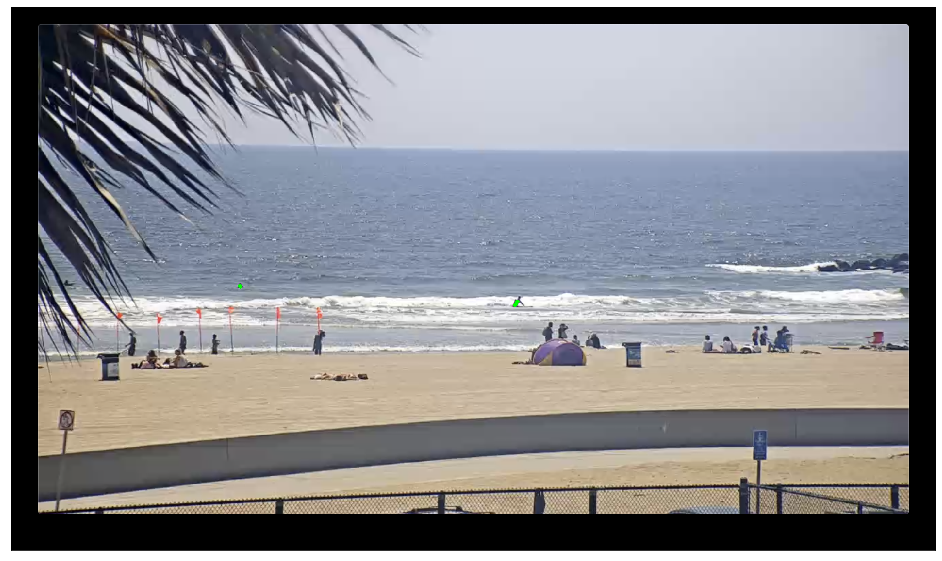

In [62]:
###############################Settings#################################
GAUSSIAN_KERNEL_SIZE = 13

GRAY_THRESH_LOW = 0
GRAY_MASK_THRESH_HIGH = 90
########################################################################
img = cv2.imread('./Images/SampleImages_001.png')

gray_img = convert_to_gray(img)

ROI_img = region_of_interest(gray_img)

gaussian_img = gaussian_blur(ROI_img,GAUSSIAN_KERNEL_SIZE)

masked_img = masking_img(gaussian_img,GRAY_THRESH_LOW,GRAY_MASK_THRESH_HIGH)

#arg(threshhold, max, type(0))
ret, thresh = cv2.threshold(masked_img, 127,255,0)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

final = cv2.drawContours(img, contours, -1, (0,255,0), 3)

final = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (20,10))
fig = plt.imshow(final)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

# plt.figure(figsize = (20,10))
# plt.imshow(img, cmap='gray')

# plt.figure(figsize = (20,10))
# plt.imshow(masked_img, cmap='gray')


take video feed

In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

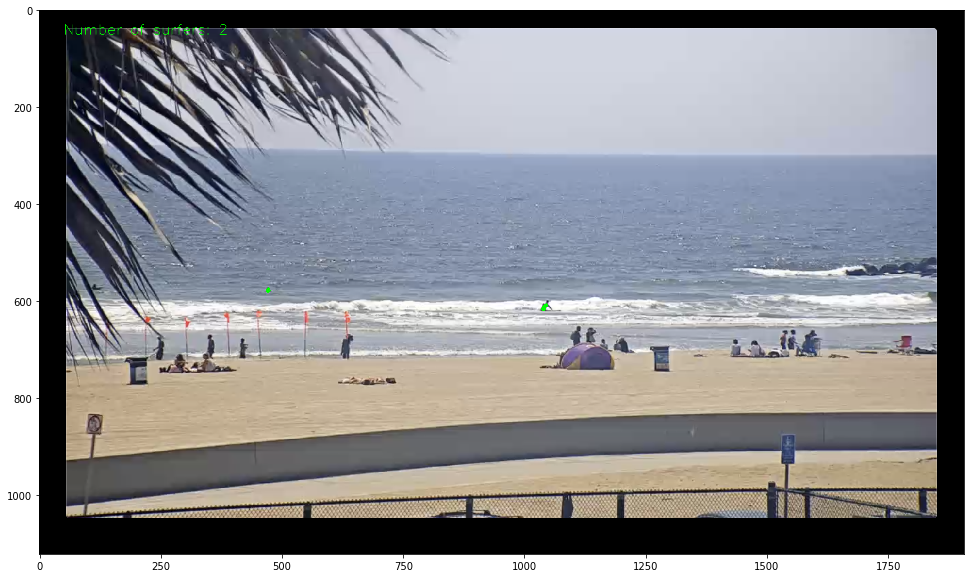

In [29]:
###############################Settings#################################
#Blur
GAUSSIAN_KERNEL_SIZE = 11 #odd number only
#Gray Thresh
GRAY_THRESH_LOW = 0
GRAY_MASK_THRESH_HIGH = 90
#Text
ORG = (50,50)
FONT = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 1.0
FONT_COLOR = (0, 255, 0)
#Prv frame
MIN_FRAME_COUNT = 7
########################################################################
#Below variables are used to get previous frame's info
cur_frame_count = 0
prv_surfer_count = 0
out_surfer_count = 0

def convert_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def region_of_interest(img):
    #hard coded since camera angle doesn't change
    #vertices = np.int32([[240,300],[1053,305],[1211,420],[180,420]])
    vertices = np.int32([[300,650],[400,450],[1600,450],[1700,650]])
    
    img = cv2.polylines(img, np.int32([vertices]), True,(0,0,0),0)
    mask = np.zeros_like(img)
    
    cv2.fillPoly(mask, np.int32([vertices]), 255)
    
    inverted_mask = cv2.bitwise_not(mask)
    
    masked_image = cv2.bitwise_or(img, inverted_mask)

    return masked_image

def gaussian_blur(img,kernel_size):
    return cv2.GaussianBlur(img,(kernel_size,kernel_size),0)

def masking_img(img, low,high):
    return cv2.inRange(img, low,high)

def add_count(img, cur_surfer_count):
    global cur_frame_count
    global prv_surfer_count
    global out_surfer_count
#     if prv_surfer_count == cur_surfer_count:
#         cur_frame_count +=1
#         if cur_frame_count == MIN_FRAME_COUNT:
#             out_surfer_count = prv_surfer_count
#             cur_frame_count = 0
#     else:
#         cur_frame_count = 0
#         prv_surfer_count = cur_surfer_count
        
    out_text = 'Number of surfers: '+ str(cur_surfer_count)
       
    cv2.putText(img, out_text, ORG, FONT , FONT_SCALE , FONT_COLOR, lineType=cv2.LINE_AA) 
    
    return img

        

def find_surfer(img):    
    gray_img = convert_to_gray(img)

    ROI_img = region_of_interest(gray_img)

    gaussian_img = gaussian_blur(ROI_img,GAUSSIAN_KERNEL_SIZE)

    masked_img = masking_img(gaussian_img,GRAY_THRESH_LOW,GRAY_MASK_THRESH_HIGH)

    #arg(threshhold, max, type(0))
    ret, thresh = cv2.threshold(masked_img, 127,255,0)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    contoured_img = cv2.drawContours(img, contours, -1, (0,255,0), 3)
    
    cur_surfer_count = str(len(contours))
    
    add_count_img = add_count(contoured_img, cur_surfer_count)
      
    return add_count_img

# cap = cv2.VideoCapture("./Videos/SampleVideo03.mp4")

# while (cap.isOpened()):
#     ret,img = cap.read()
#     img = find_surfer(img)
#     cv2.imshow('img',img)
#     k = cv2.waitKey(30)& 0xff
#     if k ==ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

img = cv2.imread('./Images/SampleImages_001.png')
img = find_surfer(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (20,10))
plt.imshow(img) 


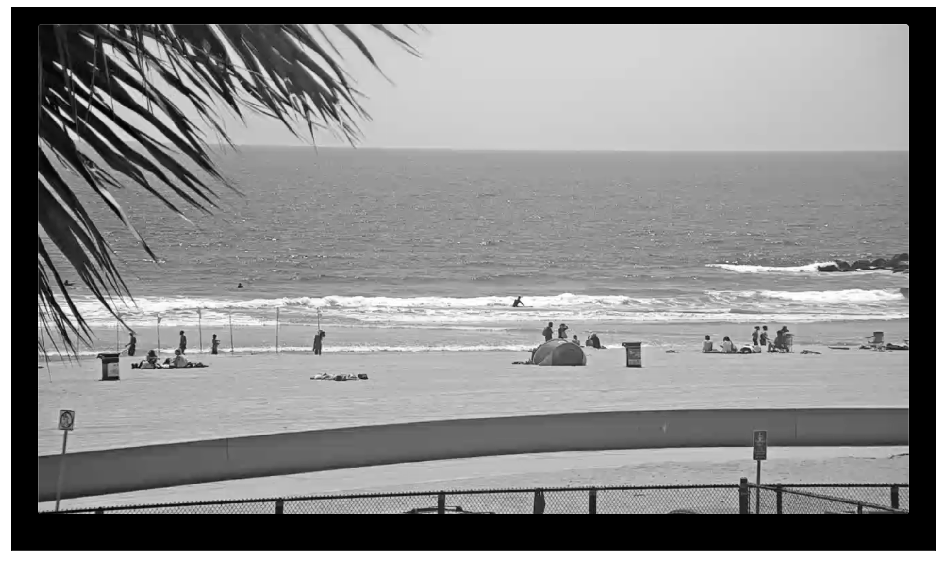

In [41]:
img = cv2.imread('./Images/SampleImages_001.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (20,10))
fig = plt.imshow(img, cmap='gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
